In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms, datasets
from torch.autograd import Variable
import numpy as np
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Datasets

In [0]:
class MNIST():
    def __init__(self, gs=True, batch_size=100):
        super(MNIST, self).__init__()
        if gs:
            im_transforms = transforms.Compose([transforms.ToTensor() , transforms.Normalize((0.5,), (0.5,))])
        else:
            im_transforms = transforms.Compose([transforms.ToTensor() , transforms.Lambda(lambda x: x.repeat(3, 1, 1)) , transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
        self.train_data = datasets.MNIST("./", train=True, download=True, transform=im_transforms)
        self.test_data = datasets.MNIST("./", train=False, download=True, transform=im_transforms)

        self.trainloader = torch.utils.data.DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.testloader = torch.utils.data.DataLoader(self.test_data, batch_size=batch_size, shuffle=False)
        return

In [0]:
class SVHN():
    def __init__(self, gs=True, batch_size=100):
        super(SVHN, self).__init__()
        if gs:
            im_transforms = transforms.Compose([transforms.Grayscale() , transforms.Resize((28,28)) , transforms.ToTensor() , transforms.Normalize((0.5,), (0.5,))])
        else:
            im_transforms = transforms.Compose([transforms.Resize((28,28)) , transforms.ToTensor() , transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
        self.train_data = datasets.SVHN("./", split="train", download=True, transform=im_transforms)
        self.test_data = datasets.SVHN("./", split="test", download=True, transform=im_transforms)

        self.trainloader = torch.utils.data.DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.testloader = torch.utils.data.DataLoader(self.test_data, batch_size=batch_size, shuffle=True)
        return

In [3]:
#svhn_gray = SVHN(batch_size=128)
#svhn_color = SVHN(gs=False)
mnist= MNIST(batch_size=128)
#mnist_color = MNIST(gs=False)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


## Defining Modules

In [0]:
class ConvLayer(nn.Module):
    def __init__(self,gs):
        super(ConvLayer, self).__init__()

        # 1 input channel, 256 output channels, 9x9 filter
        if gs:
            self.conv = nn.Sequential(
                nn.Conv2d(1, 256, 9),
                nn.ReLU()
            ).to(device)
        else:
            self.conv = nn.Sequential(
                nn.Conv2d(3, 256, 9),
                nn.ReLU()
            ).to(device)
        return
    
    def forward(self, x):
        x=x.to(device)
        return self.conv(x)

# Squash function reduces length of a vector to between 0 and 1
def squash(u):
    square = u ** 2
    square_sum = torch.sum(square, dim=2)
    norm = torch.sqrt(square_sum)
    eps=0.00001 # To prevent division by 0 incase of 0 norm.
    factor = square_sum / (norm * (1 + square_sum)+eps)
    u_squashed = factor.unsqueeze(2) * u
    return u_squashed

class PrimaryCaps(nn.Module):
    def __init__(self):
        super(PrimaryCaps, self).__init__()
        
        '''
        Primary Capsule layer contains 32 capsules, each of which contains 8 convolution outputs
        
        Final Conversion:
        [256, 20, 20] --> [8, 6, 6] x 32 capsules --> [1152, 8]
        '''
        
        # self.capsules = nn.ModuleList([
        #    nn.Conv2d(256, 8, 9, stride=2).to(device) for _ in range(32)])
        
        self.capsules = nn.Conv2d(256, 256, 9, stride=2).to(device)
        return
    
    def forward(self, x):
        # x=x.to(device)
        # u = [] # List to hold all capsules
        # for i in range(np.size(self.capsules)):
        #     u_i = self.capsules[i](x) # Element to hold 8D convolutional output for 1 capsule
        #     u_i = u_i.view(x.shape[0], -1, 1, 8) # Reshape to hold a single 8D capsule output
        #     u.append(u_i)
        # u = torch.cat(u, dim=2) # u is (batch_size, 36, 32, 8)
        #Reshape tensor to get 1152 vectors of 8D i.e (32*6*6 x 8)
        x=x.to(device)
        out = self.capsules(x) # Dimensions are [256, 6, 6]
        # # Reshape to get 1152 vectors of 8D
        # out = out.view(batch_size, -1, 8).to(device)
        out = out.view(x.shape[0], -1, 8)
        return squash(out)

class DigitCaps(nn.Module):
    def __init__(self, iterations):
        super(DigitCaps, self).__init__()
        
        '''
        W is the transformation matrix which connects each primary capsule to each of the final capsules
        '''
        self.iterations = iterations
        self.W = nn.Parameter(torch.randn((1, 1152, 10, 16, 8))*0.01,requires_grad=True)
        return
    
    def forward(self, u):
        # Dimensions of W are [1, 1152, 10, 16, 8]
        # Replicate W across all batches
        W = torch.cat([self.W for i in range(u.shape[0])], dim=0)
        W = W.to(device)
        # Now, dimensions of W are [batch_size, 1152, 10, 16, 8]
        
        # Dimensions of u are [batch_size, 1152, 8]
        # Replicate u for number of output capsules i.e. 10
        u = u.unsqueeze(2)
        u = torch.cat([u for i in range(10)],dim=2)
        # Dimensions of u are now [batch_size, 1152, 10, 8]
        # Add dimension to allow matrix multiplication with W
        u = u.unsqueeze(4)
        # Dimensions of u are now [batch_size, 1152, 10, 8, 1]

        # Now we can multiply them together to get u_hat of shape [batch_size, 1152, 10, 16, 1] which we can squeeze to get shape of [batch_size, 1152, 10, 16]
        #print(self.W.shape, u.shape)
        u_hat = torch.matmul(W, u)
        u_hat = u_hat.squeeze() #[50, 1152, 10, 16]
        # Initialize routing weights as 0
        b_ij = Variable(torch.zeros(u.shape[0], 1152, 10, 1),requires_grad=False)
        b_ij = b_ij.to(device) #[50, 1152, 10, 1]

        c_ij = F.softmax(b_ij, dim=2) # Initial Iteration with Equal weights
        c_ij = c_ij.detach()
        s_j = torch.sum(u_hat * c_ij, dim=1)
        v_j = squash(s_j)
        routes = []
        routes.append(c_ij)
        outputs = []
        outputs.append(v_j)
        num_routing_iterations = self.iterations
        for i in range(num_routing_iterations):
            # Add dimension to actual to allow multiplication
            agreement = torch.sum(u_hat*v_j.unsqueeze(1),dim=3, keepdim=True) #[50, 1152, 10, 1]
            b_ij = b_ij + agreement #[50, 1152, 10, 1]
            c_ij = F.softmax(b_ij, dim=2) # Dimensions are same as b_ij i.e. [batch_size, 1152, 10, 1]
            c_ij = c_ij.detach()
            s_j = torch.sum(u_hat * c_ij, dim=1) # Dimensions are [batch_size, 10, 16] ... The weight c_ij is multiplied to each of the 16 dimensions in u_hat.
            v_j = squash(s_j)                    # Weighted summation over all vectors is then performed
            routes.append(c_ij)
            outputs.append(v_j)
        routes = torch.stack(routes,dim=0)
        outputs = torch.stack(outputs,dim=0)
        return v_j, routes, u_hat, outputs

class Decoder(nn.Module):
    def __init__(self,gs):
        super(Decoder, self).__init__()
        self.gs = gs
        if gs:
            self.decoder = nn.Sequential(
                            nn.Linear(16, 512),
                            nn.ReLU(),
                            nn.Linear(512, 1024),
                            nn.ReLU(),
                            nn.Linear(1024, 784),
                            nn.Sigmoid()
                            ).to(device)
        else:
            self.decoder = nn.Sequential(
                            nn.Linear(16, 512),
                            nn.ReLU(),
                            nn.Linear(512, 1024),
                            nn.ReLU(),
                            nn.Linear(1024, 784*3),
                            nn.Sigmoid()
                            ).to(device)

    def forward(self, v):
        # mask: [batch_size, 10, 16]
        # mask = torch.stack([labels for i in range(v.shape[2])], dim=2)
        # mask = mask.to(device)

        # v: [batch_size, 10, 16]
        # v_masked = mask * v
        # v_masked = torch.sum(v_masked, dim=1)
        _, pred = torch.max(torch.norm(v, dim=2), dim=1)
        o = torch.stack([v[i,pred[i]] for i in range(v.shape[0])])
        if self.gs:
            recon = self.decoder(o).view(v.shape[0],28,28)
        else:
            recon = self.decoder(o).view(v.shape[0],3,28,28)
        return recon

## Complete Model

In [0]:
class CapsNet(nn.Module):
    def __init__(self, gs=True, iterations=3):
        super(CapsNet, self).__init__()
        self.conv = ConvLayer(gs)
        self.pcaps = PrimaryCaps()
        self.dcaps = DigitCaps(iterations=iterations)
        self.decoder = Decoder(gs)


    def forward(self, x):
        out = self.dcaps(self.pcaps(self.conv(x)))
        return out
    
    def margin_loss(self, v, labels):
        # Dimensions of v are [batch_size, 10, 16]
        labels = torch.sparse.torch.eye(10).index_select(dim=0, index=labels)
        labels = labels.to(device)
        v_c = torch.norm(v,dim=2)
        # v_c is [batch_size, 10]
        left = ((F.relu(0.9 - v_c))**2)
        right = ((F.relu(v_c - 0.1))**2)
        margin_loss = labels*left + 0.5*(1.0-labels)*right
        return torch.sum(margin_loss,dim=1).mean()
    
    def reconstruction_loss(self, v, image):
        image = image.to(device)
        recon = self.decoder(v)
        img = image.view(image.shape[0],-1)
        recon = recon.view(recon.shape[0],-1)
        diff = (recon-img)**2
        return torch.sum(diff,dim=1).mean()
    
    def loss(self, v, labels, image):
        ml = self.margin_loss(v, labels)
        rl = self.reconstruction_loss(v, image)
        return ml+0.0005*rl

In [0]:
dataiter = iter(mnist.trainloader)
img,lbl = dataiter.next()
capsnet = CapsNet()
capsnet = capsnet.to(device)

In [0]:
out = capsnet(img)

## Training

In [0]:
# capsnet = CapsNet()
# capsnet.to(device)
epochs = 10
optimizer = torch.optim.Adam(capsnet.parameters())
print('ok')

ok


In [0]:
def n_parameters(model):
        return np.sum([np.prod(x.size()) for x in model.parameters()])

n_parameters(capsnet)

8141840

In [0]:
print('Starting')
print('Running for',epochs,'Epochs')
print('Batch Size:', mnist.trainloader.batch_size)
print('No of batches per epoch:', int(len(mnist.train_data.data)/mnist.trainloader.batch_size))
losses = []
test_acc = []
for epoch in range(epochs):
    loss2 = []
    for i, data in enumerate(mnist.trainloader, 0):
        capsnet.train()
        inputs, labels = data
        optimizer.zero_grad()
        out,_,_,_ = capsnet(inputs)
        loss = capsnet.loss(out, labels, inputs)
        loss.backward()
        optimizer.step()
        loss2.append(loss.item())
        if (((i+1) % 10) == 0):
            print("\rEpoch #:",epoch+1, "  Batch #:", i+1,end="")
    l = np.sum(loss2)/(len(loss2))
    print('\nEpoch #:', epoch+1, '  Training Loss:', l)
    correct = 0
    total = 0
    # with torch.no_grad():
    #     for data in mnist.testloader:
    #         capsnet.eval()
    #         images, labels = data
    #         outputs,_,_,_ = capsnet(images)
    #         norm = torch.norm(outputs, dim=2)
    #         predicted = np.argmax(norm.cpu().numpy(),axis=1)
    #         total += labels.size(0)
    #         correct += (predicted == labels.cpu().numpy()).sum().item()
    # acc = (100 * correct / total)
    # print('CapsNet Testing Accuracy on MNIST: ',acc, '%')
    # test_acc.append(acc)
    # if max(test_acc)==acc:
    #     torch.save(capsnet.state_dict(), 'gdrive/My Drive/capsnet_40_epochs.pth')
    losses.append(l)
print('Finished')

Starting
Running for 10 Epochs
Batch Size: 128
No of batches per epoch: 468
Epoch #: 1   Batch #: 460
Epoch #: 1   Training Loss: 0.339205963461638
Epoch #: 2   Batch #: 460
Epoch #: 2   Training Loss: 0.33842078480385007
Epoch #: 3   Batch #: 460
Epoch #: 3   Training Loss: 0.3391061447449584
Epoch #: 4   Batch #: 460
Epoch #: 4   Training Loss: 0.3401303166773782
Epoch #: 5   Batch #: 460
Epoch #: 5   Training Loss: 0.3390621660487738
Epoch #: 6   Batch #: 460
Epoch #: 6   Training Loss: 0.3389718974195818
Epoch #: 7   Batch #: 460
Epoch #: 7   Training Loss: 0.3385729589569035
Epoch #: 8   Batch #: 460
Epoch #: 8   Training Loss: 0.3385851078831565
Epoch #: 9   Batch #: 460
Epoch #: 9   Training Loss: 0.33825773299375833
Epoch #: 10   Batch #: 460
Epoch #: 10   Training Loss: 0.3385466109079593
Finished


In [0]:
torch.save(capsnet.state_dict(), 'gdrive/My Drive/final_capsnet_joint.pth')

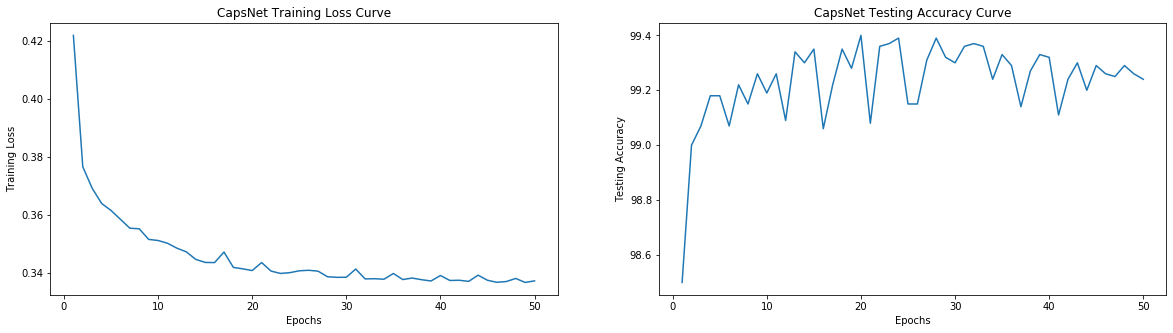

In [0]:
plt.figure(figsize=(20,5))
plt.subplot(121)
x = np.arange(1,len(losses)+1,1)
plt.plot(x,losses)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('CapsNet Training Loss Curve')

plt.subplot(122)
plt.plot(x,test_acc)
plt.xlabel('Epochs')
plt.ylabel('Testing Accuracy')
plt.title('CapsNet Testing Accuracy Curve')

plt.show()

## Accuracies

In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in mnist_gray.trainloader:
        images, labels = data
        outputs,_ = capsnet(images)
        norm = torch.norm(outputs, dim=2)
        predicted = np.argmax(norm.cpu().numpy(),axis=1)
        total += labels.size(0)
        correct += (predicted == labels.cpu().numpy()).sum().item()
acc = (100 * correct / total)
print('CapsNet Training Accuracy on MNIST: ',acc, '%')

CapsNet Training Accuracy on MNIST:  100.0 %


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in mnist_gray.testloader:
        images, labels = data
        outputs,_ = capsnet(images)
        norm = torch.norm(outputs, dim=2)
        predicted = np.argmax(norm.cpu().numpy(),axis=1)
        total += labels.size(0)
        correct += (predicted == labels.cpu().numpy()).sum().item()
acc = (100 * correct / total)
print('CapsNet Testing Accuracy on MNIST: ',acc, '%')

CapsNet Testing Accuracy on MNIST:  99.24 %


## CapsNet reconstructions for MNIST

In [0]:
dataiter = iter(mnist_gray.testloader)
img, lbl = dataiter.next()
print(img.shape)
print(lbl.shape)
out,_ = capsnet(img)
recon = capsnet.decoder(out)

torch.Size([128, 1, 28, 28])
torch.Size([128])


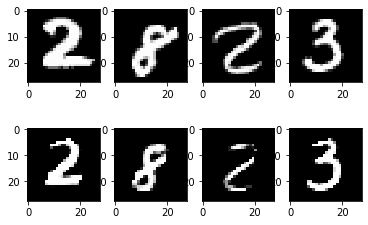

In [0]:
plt.figure()

plt.subplot(241)
plt.imshow(img[10][0].cpu().detach().numpy(), cmap='gray')
plt.subplot(242)
plt.imshow(img[20][0].cpu().detach().numpy(), cmap='gray')
plt.subplot(243)
plt.imshow(img[30][0].cpu().detach().numpy(), cmap='gray')
plt.subplot(244)
plt.imshow(img[40][0].cpu().detach().numpy(), cmap='gray')

plt.subplot(245)
plt.imshow(recon[10].cpu().detach().numpy(), cmap='gray')
plt.subplot(246)
plt.imshow(recon[20].cpu().detach().numpy(), cmap='gray')
plt.subplot(247)
plt.imshow(recon[30].cpu().detach().numpy(), cmap='gray')
plt.subplot(248)
plt.imshow(recon[40].cpu().detach().numpy(), cmap='gray')
plt.show()


In [0]:
def test_recon(digit_cap_out,testimages):
    #print(digit_cap_out.size())
    #print(testimages.size())
    data_np=testimages.detach().cpu().numpy()
    plt.imshow(data_np[10,:,:,:].squeeze(),cmap='gray')
    plt.title('real')
    plt.show()
    listt=[-0.25,-0.175,0.0,0.175,0.25]
    for j in range(16):
      plt.figure()
      #ind=np.random.randint(0,15)
      for i in range(5):
        new=torch.tensor(digit_cap_out)
        new[10,:,j]=new[10,:,j]+listt[i]
        recon=capsnet.decoder(new)
        recon_np=recon.detach().cpu().numpy()
        plt.subplot(150+i+1,)
        plt.imshow(recon_np[10,:,:].squeeze(),cmap='gray')
        plt.title(str(j)+'_'+str(listt[i]))
      plt.show()

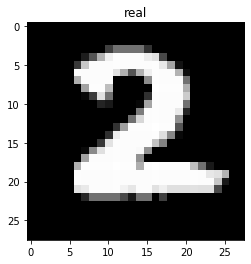

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


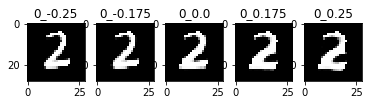

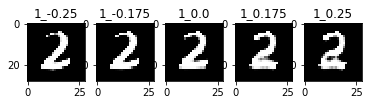

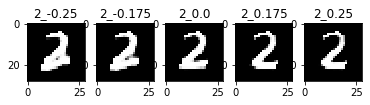

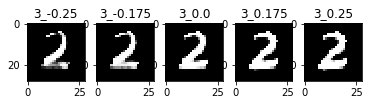

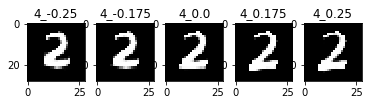

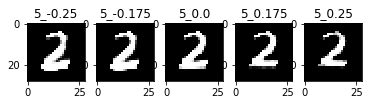

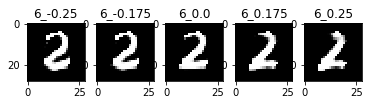

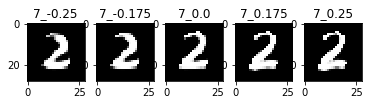

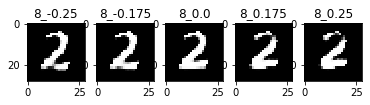

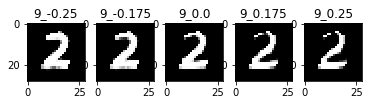

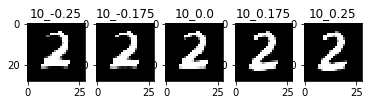

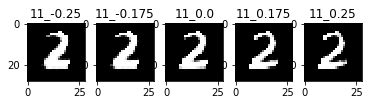

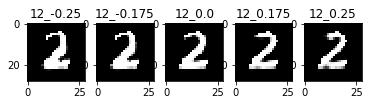

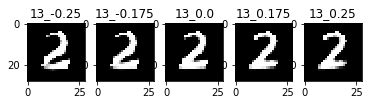

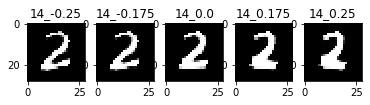

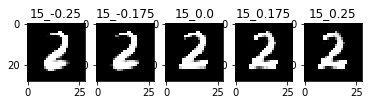

In [0]:
test_recon(out,img)

## Distribution of CapsNet outputs on MNIST Training Set

In [0]:
state_dict = torch.load('gdrive/My Drive/capsnet_joint.pth')
capsnet = CapsNet()
capsnet.to(device)
capsnet.load_state_dict(state_dict)
capsnet.eval()
print('ok')

ok


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in mnist_gray.trainloader:
        images, labels = data
        outputs,_ = capsnet(images)
        norm = torch.norm(outputs, dim=2)
        predicted = np.argmax(norm.cpu().numpy(),axis=1)
        total += labels.size(0)
        correct += (predicted == labels.cpu().numpy()).sum().item()
acc = (100 * correct / total)
print('CapsNet Training Accuracy on MNIST: ',acc, '%')

CapsNet Training Accuracy on MNIST:  100.0 %


In [0]:
correct = 0
total = 0
with torch.no_grad():
    for data in mnist_gray.testloader:
        images, labels = data
        outputs,_ = capsnet(images)
        norm = torch.norm(outputs, dim=2)
        predicted = np.argmax(norm.cpu().numpy(),axis=1)
        total += labels.size(0)
        correct += (predicted == labels.cpu().numpy()).sum().item()
acc = (100 * correct / total)
print('CapsNet Testing Accuracy on MNIST: ',acc, '%')

CapsNet Testing Accuracy on MNIST:  99.37 %


In [0]:
list_of_outs = []
lbls = []
with torch.no_grad():
    for i,data in enumerate(mnist_gray.trainloader,0):
        print('\r','%.2f' %((i+1)*mnist_gray.trainloader.batch_size*100/len(mnist_gray.train_data.data)),'%',end='')
        images, labels = data
        lbls.append(labels)
        outputs,_ = capsnet(images)
        list_of_outs.append(outputs.cpu().numpy())
outs = np.concatenate(list_of_outs,axis=0)
lbls = np.concatenate(lbls, axis=0)
print("\n",outs.shape, lbls.shape)

 100.05 %
 (60000, 10, 16) (60000,)


In [0]:
class_means = []
class_vars = []
for i in range(10):
    ind = lbls==i    
    o = outs[ind][:,i,:]
    class_means.append(np.mean(o,axis=0))
    class_vars.append(np.var(o,axis=0))

### Mean reconstructions of each class latent capsules

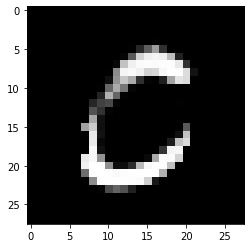

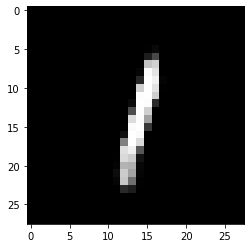

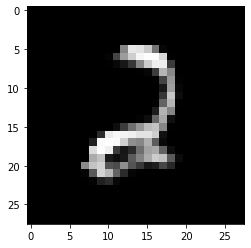

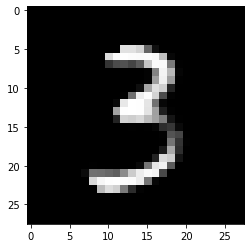

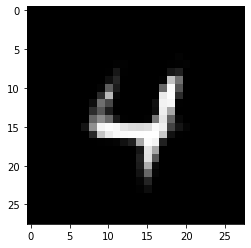

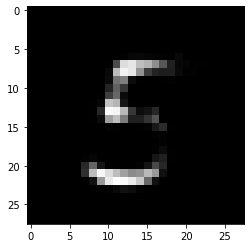

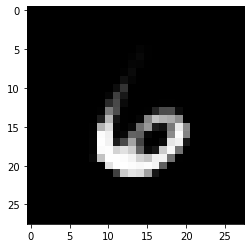

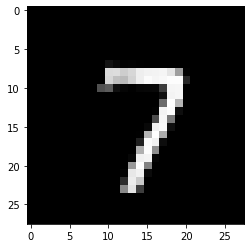

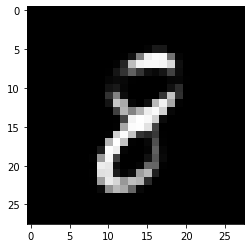

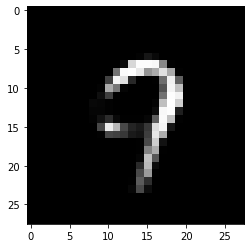

In [0]:
plt.figure()
for i in range(len(class_means)):
    recon = capsnet.decoder.decoder(torch.Tensor(class_means[i]).to(device)).view(28,28)
    plt.imshow(recon.detach().cpu().numpy(),cmap='gray')
    plt.show()

### Morphing between classes

In [0]:
diff = class_means[1]-class_means[8]
diff

array([-0.13962361, -0.32283562, -0.21445648,  0.02617125,  0.5067197 ,
       -0.03556996,  0.46017453, -0.05456886, -0.20541438,  0.22391817,
       -0.18031642, -0.5690621 , -0.12579936,  0.19457561,  0.09326008,
       -0.15012924], dtype=float32)

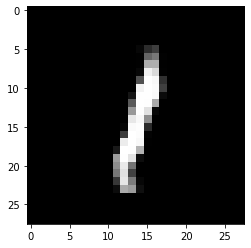

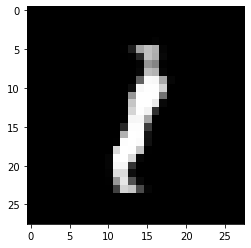

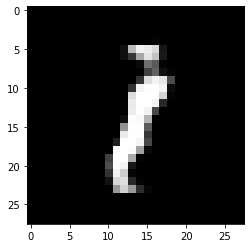

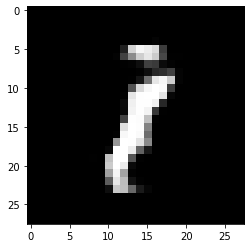

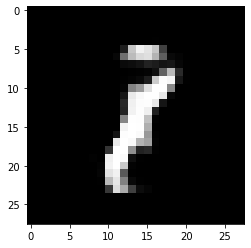

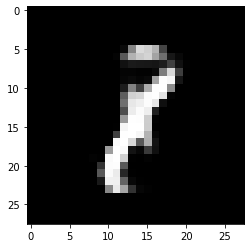

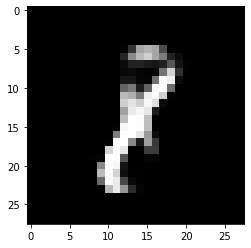

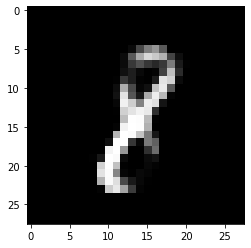

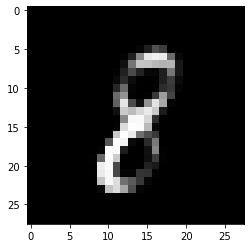

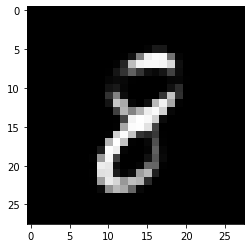

<Figure size 432x288 with 0 Axes>

In [0]:
plt.figure()
sample = class_means[1].copy()
for i in range(10):
    sample = sample-(diff/10)
    recon = capsnet.decoder.decoder(torch.Tensor(sample).to(device)).view(28,28)
    plt.imshow(recon.detach().cpu().numpy(),cmap='gray')
    plt.show()
    plt.savefig("gdrive/My Drive/gan.png")

## Printing Routing Weights (Dynamic Routing)

In [0]:
class MNIST():
    def __init__(self, gs=True, batch_size=100):
        super(MNIST, self).__init__()
        if gs:
            im_transforms = transforms.Compose([transforms.ToTensor() , transforms.Normalize((0.5,), (0.5,))])
        else:
            im_transforms = transforms.Compose([transforms.ToTensor() , transforms.Lambda(lambda x: x.repeat(3, 1, 1)) , transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
        self.train_data = datasets.MNIST("./", train=True, download=True, transform=im_transforms)
        self.test_data = datasets.MNIST("./", train=False, download=True, transform=im_transforms)

        self.trainloader = torch.utils.data.DataLoader(self.train_data, batch_size=batch_size, shuffle=False)
        self.testloader = torch.utils.data.DataLoader(self.test_data, batch_size=batch_size, shuffle=False)
        return

In [0]:
mnist_gray = MNIST(batch_size=128)

In [0]:
dataiter = iter(mnist_gray.testloader)
img, lbl = dataiter.next()
lbl

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5])

In [0]:
img[(lbl == 9)].shape

torch.Size([17, 1, 28, 28])

In [0]:
lcaps, c = capsnet.dcaps(capsnet.pcaps(capsnet.conv(img[lbl==9])))
print(lcaps.shape, c.shape)

torch.Size([17, 10, 16]) torch.Size([17, 1152, 10, 1])


In [0]:
print(c[0][0])
print(c[0][10])
print(c[0][100])
print(c[0][1000])

tensor([[0.0995],
        [0.1001],
        [0.0996],
        [0.1001],
        [0.1002],
        [0.0993],
        [0.0999],
        [0.0998],
        [0.0998],
        [0.1018]], device='cuda:0', grad_fn=<SelectBackward>)
tensor([[0.0980],
        [0.0979],
        [0.0981],
        [0.0982],
        [0.0983],
        [0.0982],
        [0.0982],
        [0.0985],
        [0.0988],
        [0.1157]], device='cuda:0', grad_fn=<SelectBackward>)
tensor([[0.0995],
        [0.0993],
        [0.0989],
        [0.0994],
        [0.0994],
        [0.0994],
        [0.0995],
        [0.0989],
        [0.0990],
        [0.1068]], device='cuda:0', grad_fn=<SelectBackward>)
tensor([[0.1002],
        [0.1004],
        [0.1000],
        [0.1004],
        [0.1003],
        [0.0999],
        [0.1003],
        [0.1004],
        [0.1001],
        [0.0981]], device='cuda:0', grad_fn=<SelectBackward>)


In [0]:
print(c[0][0])
print(c[0][10])
print(c[0][100])
print(c[0][1000])

tensor([[0.0960],
        [0.1060],
        [0.0960],
        [0.1061],
        [0.1061],
        [0.0960],
        [0.0960],
        [0.0960],
        [0.0960],
        [0.1061]], device='cuda:0', grad_fn=<SelectBackward>)
tensor([[0.0989],
        [0.0989],
        [0.0989],
        [0.0989],
        [0.0989],
        [0.0989],
        [0.0989],
        [0.0989],
        [0.0989],
        [0.1100]], device='cuda:0', grad_fn=<SelectBackward>)
tensor([[0.0989],
        [0.0989],
        [0.0989],
        [0.0989],
        [0.0989],
        [0.0989],
        [0.0989],
        [0.0989],
        [0.0989],
        [0.1097]], device='cuda:0', grad_fn=<SelectBackward>)
tensor([[0.1029],
        [0.1029],
        [0.0931],
        [0.1029],
        [0.1029],
        [0.0931],
        [0.1029],
        [0.1029],
        [0.1029],
        [0.0931]], device='cuda:0', grad_fn=<SelectBackward>)


## Visualizing Primary Caps Predictions

In [0]:
state_dict = torch.load('gdrive/My Drive/PyTorch Saved Stuff/final_capsnet_joint.pth')
capsnet = CapsNet()
capsnet.to(device)
capsnet.load_state_dict(state_dict)
capsnet.eval()
dataiter = iter(mnist.trainloader)
img,lbl = dataiter.next()
print('ok')

ok


In [0]:
out, routes = capsnet(img)

In [0]:
np.where(lbl==4)

(array([  3,   5,  10,  25,  36,  39,  40,  63,  80,  92, 110, 118, 121,
        123]),)

4

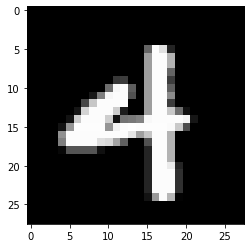

In [0]:
ind = 10
plt.imshow(img[ind].view(28,28).cpu().numpy(),cmap='gray')
cls = lbl[ind].item()
cls

In [0]:
rts = routes[ind][:,cls,0]
primary_caps = capsnet.pcaps(capsnet.conv(img))[ind]
for p in capsnet.dcaps.parameters():
    W = p
wts = W[0,:,cls,:,:]

In [0]:
indices = np.argsort(-rts.cpu())[:10]
indices

tensor([985, 247, 670, 602, 229, 490, 272, 248, 325, 118])

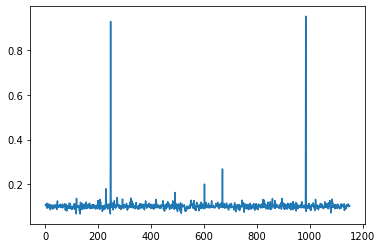

In [0]:
plt.plot(rts.cpu())

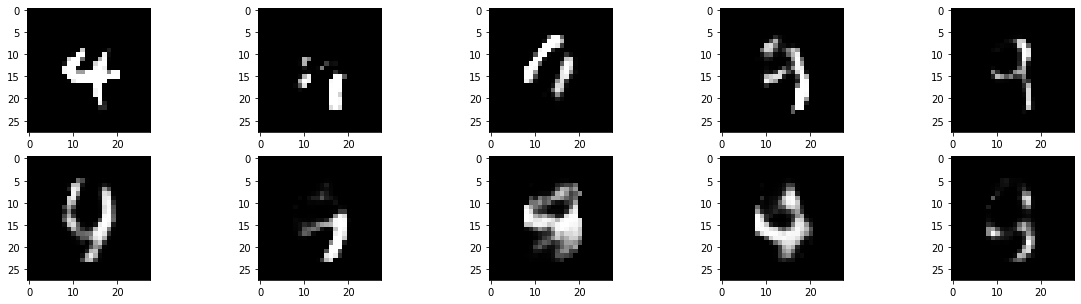

In [0]:
fig, axs = plt.subplots(2,5, figsize=(20, 5))
axs = axs.ravel()
for i in range(len(indices)):
    pred = torch.matmul(wts[indices[i]],primary_caps[indices[i]])
    recon = capsnet.decoder(pred.unsqueeze(0).unsqueeze(0))
    axs[i].imshow(recon.view(28,28).detach().cpu().numpy(),cmap='gray')

In [0]:
cls = 9
rts = routes[ind][:,cls,0]
primary_caps = capsnet.pcaps(capsnet.conv(img))[ind]
for p in capsnet.dcaps.parameters():
    W = p
wts = W[0,:,cls,:,:]

In [0]:
indices = np.argsort(-rts.cpu())[:10]
indices

tensor([1112,  779,  117,  778,  311,  240,  216,  257, 1081,  986])

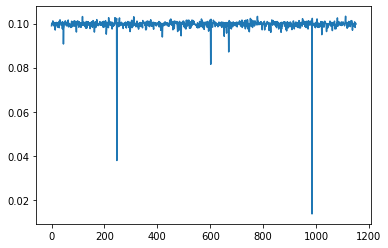

In [0]:
plt.plot(rts.cpu())

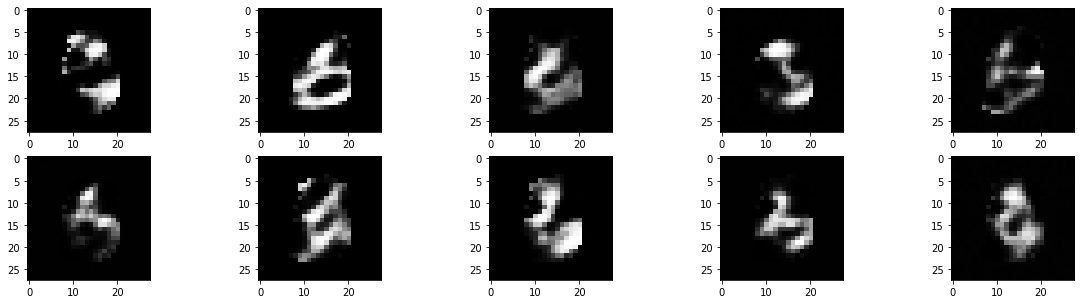

In [0]:
fig, axs = plt.subplots(2,5, figsize=(20, 5))
axs = axs.ravel()
for i in range(len(indices)):
    pred = torch.matmul(wts[indices[i]],primary_caps[indices[i]])
    recon = capsnet.decoder(pred.unsqueeze(0).unsqueeze(0))
    axs[i].imshow(recon.view(28,28).detach().cpu().numpy(),cmap='gray')

## Routing Experiments

In [7]:
state_dict = torch.load('gdrive/My Drive/PyTorch Saved Stuff/final_capsnet_joint.pth')
capsnet = CapsNet()
capsnet.to(device)
capsnet.load_state_dict(state_dict)
capsnet.eval()
img,lbl = next(iter(mnist.testloader))
print('ok')

ok


In [0]:
v, routes, u_hat, outs = capsnet(img)

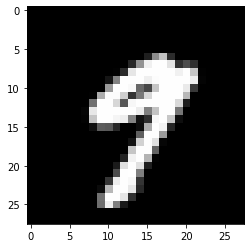

In [64]:

plt.imshow(img[20].squeeze().cpu().numpy(), cmap="gray")

### Evolution of Routes with Training

#### Untrained Routes progression

In [0]:
v,routes,u_hat,outs = capsnet(img)

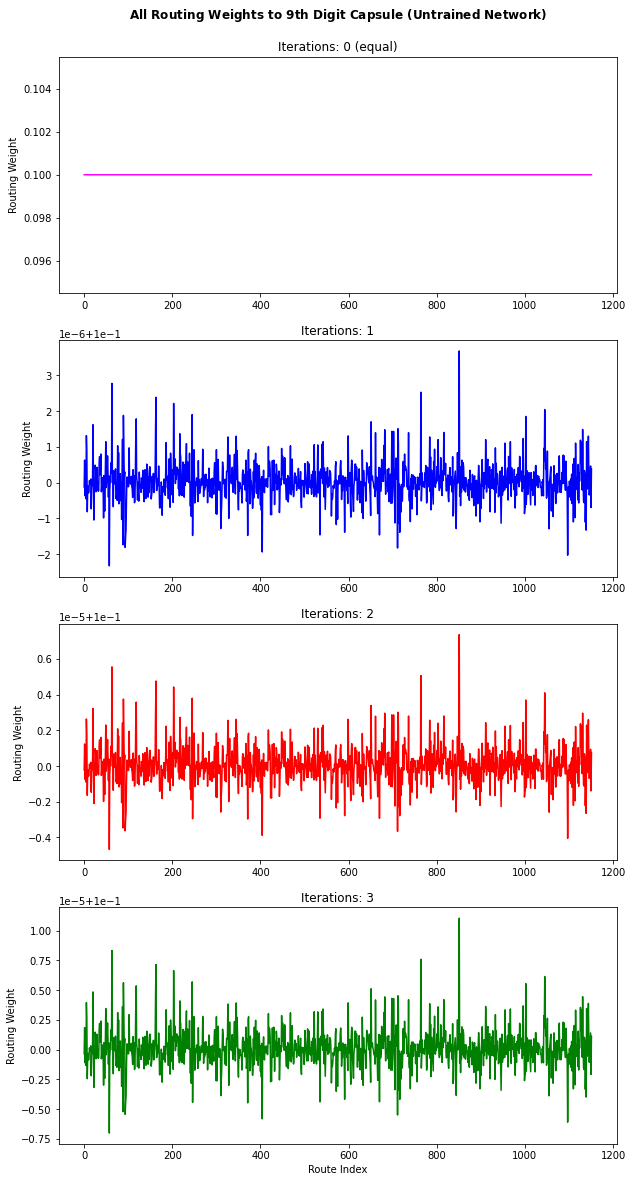

In [0]:
# Routes from 1st primary capsule to 7th (true digit capsule) with equal routes
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title(r"$\bf{All\ Routing\ Weights\ to\ 9th\ Digit\ Capsule\ (Untrained\ Network)}$"+"\n\n")
ax.set_xlabel("Route Index")

ax1 = fig.add_subplot(4,1,1)
ax1.set_title("Iterations: 0 (equal)")
#ax1.set_xlabel("Route Index")
ax1.set_ylabel("Routing Weight")
ax2 = fig.add_subplot(4,1,2)
ax2.set_title("Iterations: 1")
#ax2.set_xlabel("Route Index")
ax2.set_ylabel("Routing Weight")
ax3 = fig.add_subplot(4,1,3)
ax3.set_title("Iterations: 2")
#ax3.set_xlabel("Route Index")
ax3.set_ylabel("Routing Weight")
ax4 = fig.add_subplot(4,1,4)
ax4.set_title("Iterations: 3")
#ax4.set_xlabel("Route Index")
ax4.set_ylabel("Routing Weight")

ax1.plot(routes[0,20,:,9].cpu().numpy(),color='magenta')

# Routes from 1st primary capsule to 7th (true digit capsule) with 1 iteration
ax2.plot(routes[1,20,:,9].cpu().numpy(), color='blue')

# Routes from 1st primary capsule to 7th (true digit capsule) with 2 iterations
ax3.plot(routes[2,20,:,9].cpu().numpy(),color='red')

# Routes from 1st primary capsule to 7th (true digit capsule) with 3 iterations
ax4.plot(routes[3,20,:,9].cpu().numpy(),color='green')

fig.savefig("Untrained CapsNet Routes progression")

In [0]:
# Sparsity
n_of_sparse_routes_0 = torch.sum((routes[3] > 0.2))
print("Sparsity:",n_of_sparse_routes_0.item())

Sparsity: 0


#### 10 epochs

In [0]:
v,routes,u_hat,outs = capsnet(img)

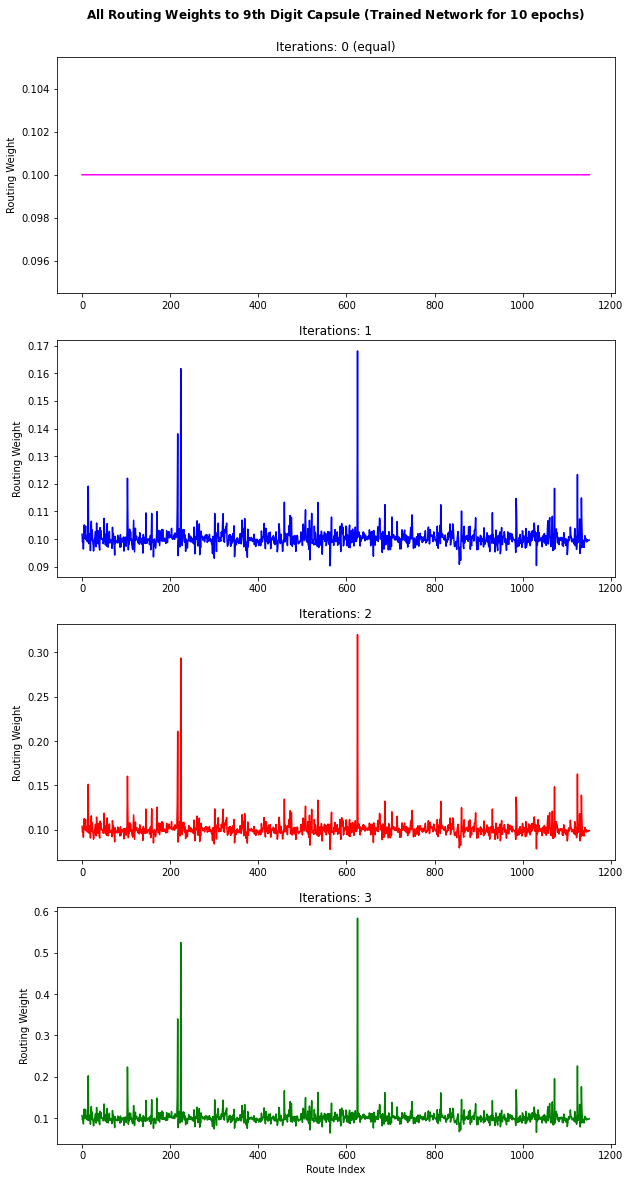

In [0]:
# Routes from 1st primary capsule to 7th (true digit capsule) with equal routes
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title(r"$\bf{All\ Routing\ Weights\ to\ 9th\ Digit\ Capsule\ (Trained\ Network\ for\ 10\ epochs)}$"+"\n\n")
ax.set_xlabel("Route Index")

ax1 = fig.add_subplot(4,1,1)
ax1.set_title("Iterations: 0 (equal)")
#ax1.set_xlabel("Route Index")
ax1.set_ylabel("Routing Weight")
ax2 = fig.add_subplot(4,1,2)
ax2.set_title("Iterations: 1")
#ax2.set_xlabel("Route Index")
ax2.set_ylabel("Routing Weight")
ax3 = fig.add_subplot(4,1,3)
ax3.set_title("Iterations: 2")
#ax3.set_xlabel("Route Index")
ax3.set_ylabel("Routing Weight")
ax4 = fig.add_subplot(4,1,4)
ax4.set_title("Iterations: 3")
#ax4.set_xlabel("Route Index")
ax4.set_ylabel("Routing Weight")

ax1.plot(routes[0,20,:,9].cpu().numpy(),color='magenta')

# Routes from 1st primary capsule to 7th (true digit capsule) with 1 iteration
ax2.plot(routes[1,20,:,9].cpu().numpy(), color='blue')

# Routes from 1st primary capsule to 7th (true digit capsule) with 2 iterations
ax3.plot(routes[2,20,:,9].cpu().numpy(),color='red')

# Routes from 1st primary capsule to 7th (true digit capsule) with 3 iterations
ax4.plot(routes[3,20,:,9].cpu().numpy(),color='green')

fig.savefig("10 epochs CapsNet Routes progression")

In [0]:
# Sparsity
n_of_sparse_routes_0 = torch.sum((routes[3] > 0.2))
print("Sparsity:",n_of_sparse_routes_0.item())

Sparsity: 740


#### 20 epochs

In [0]:
v,routes_20,u_hat,outs_20 = capsnet(img)

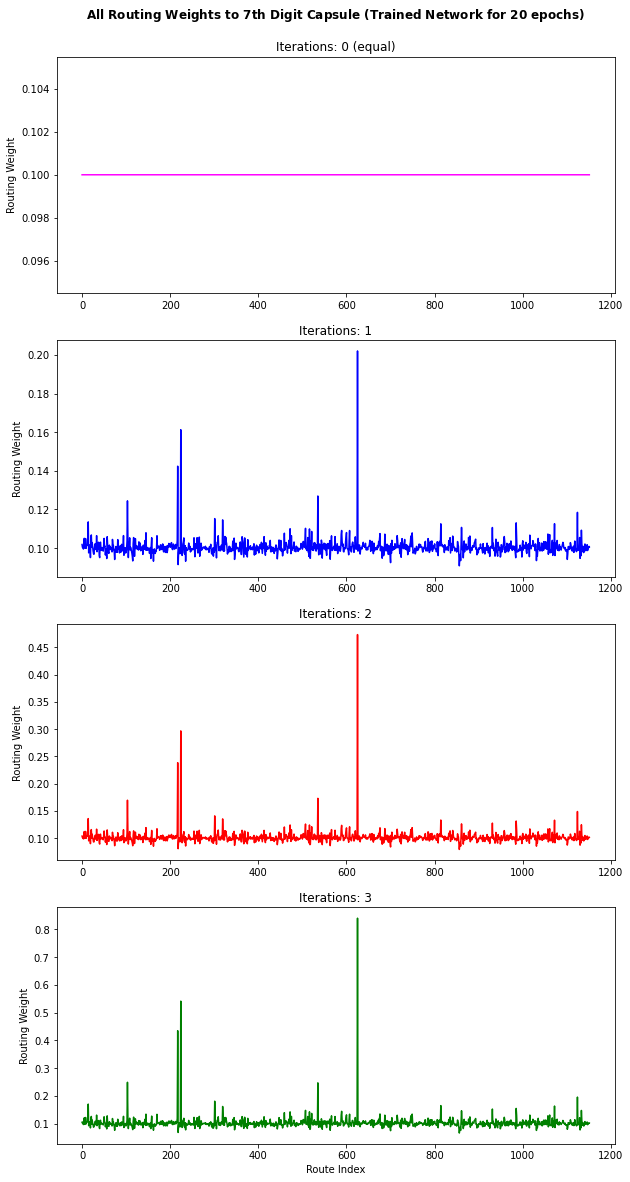

In [0]:
# Routes from 1st primary capsule to 7th (true digit capsule) with equal routes
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title(r"$\bfAll\ Routing\ Weights\ to\ 7th\ Digit\ Capsule\ (Trained\ Network\ for\ 20\ epochs)}$"+"\n\n")
ax.set_xlabel("Route Index")

ax1 = fig.add_subplot(4,1,1)
ax1.set_title("Iterations: 0 (equal)")
#ax1.set_xlabel("Route Index")
ax1.set_ylabel("Routing Weight")
ax2 = fig.add_subplot(4,1,2)
ax2.set_title("Iterations: 1")
#ax2.set_xlabel("Route Index")
ax2.set_ylabel("Routing Weight")
ax3 = fig.add_subplot(4,1,3)
ax3.set_title("Iterations: 2")
#ax3.set_xlabel("Route Index")
ax3.set_ylabel("Routing Weight")
ax4 = fig.add_subplot(4,1,4)
ax4.set_title("Iterations: 3")
#ax4.set_xlabel("Route Index")
ax4.set_ylabel("Routing Weight")

ax1.plot(routes_20[0,20,:,9].cpu().numpy(),color='magenta')

# Routes from 1st primary capsule to 7th (true digit capsule) with 1 iteration
ax2.plot(routes_20[1,20,:,9].cpu().numpy(), color='blue')

# Routes from 1st primary capsule to 7th (true digit capsule) with 2 iterations
ax3.plot(routes_20[2,20,:,9].cpu().numpy(),color='red')

# Routes from 1st primary capsule to 7th (true digit capsule) with 3 iterations
ax4.plot(routes_20[3,20,:,9].cpu().numpy(),color='green')

fig.savefig("20 epochs trained CapsNet Routes progression")

In [0]:
# Sparsity
n_of_sparse_routes_20 = torch.sum((routes_20[3] > 0.2))
print("Sparsity:",n_of_sparse_routes_20.item())

Sparsity: 632


#### 30 epochs

In [0]:
v,routes,u_hat,outs = capsnet(img)

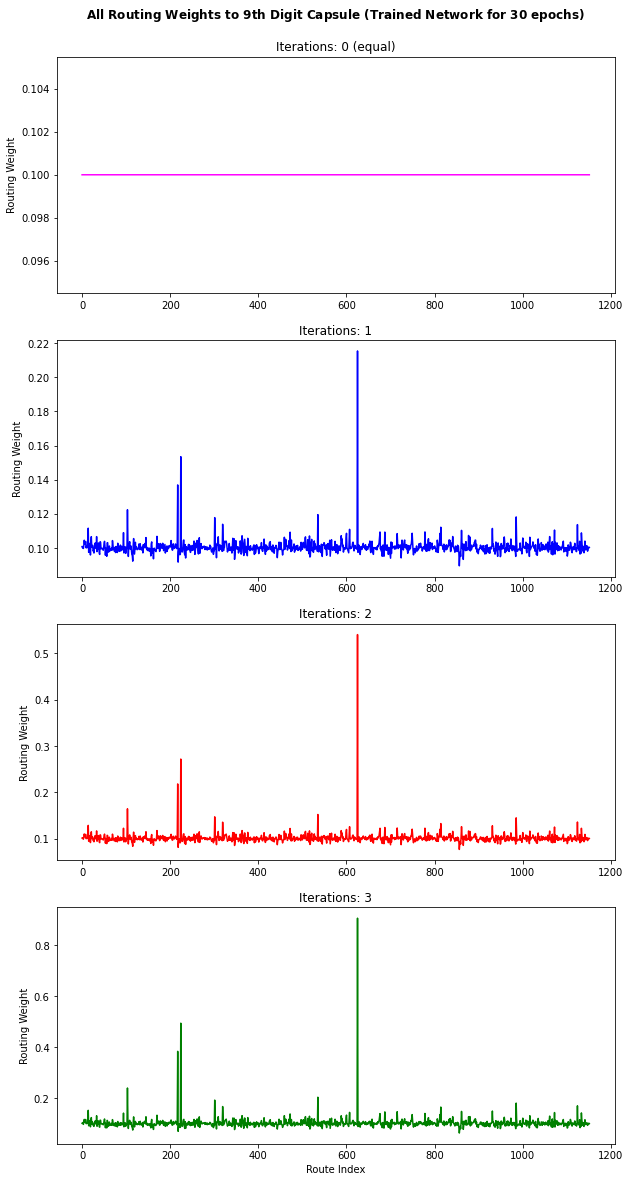

In [0]:
# Routes from 1st primary capsule to 7th (true digit capsule) with equal routes
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title(r"$\bf{All\ Routing\ Weights\ to\ 9th\ Digit\ Capsule\ (Trained\ Network\ for\ 30\ epochs)}$"+"\n\n")
ax.set_xlabel("Route Index")

ax1 = fig.add_subplot(4,1,1)
ax1.set_title("Iterations: 0 (equal)")
#ax1.set_xlabel("Route Index")
ax1.set_ylabel("Routing Weight")
ax2 = fig.add_subplot(4,1,2)
ax2.set_title("Iterations: 1")
#ax2.set_xlabel("Route Index")
ax2.set_ylabel("Routing Weight")
ax3 = fig.add_subplot(4,1,3)
ax3.set_title("Iterations: 2")
#ax3.set_xlabel("Route Index")
ax3.set_ylabel("Routing Weight")
ax4 = fig.add_subplot(4,1,4)
ax4.set_title("Iterations: 3")
#ax4.set_xlabel("Route Index")
ax4.set_ylabel("Routing Weight")

ax1.plot(routes[0,20,:,9].cpu().numpy(),color='magenta')

# Routes from 1st primary capsule to 7th (true digit capsule) with 1 iteration
ax2.plot(routes[1,20,:,9].cpu().numpy(), color='blue')

# Routes from 1st primary capsule to 7th (true digit capsule) with 2 iterations
ax3.plot(routes[2,20,:,9].cpu().numpy(),color='red')

# Routes from 1st primary capsule to 7th (true digit capsule) with 3 iterations
ax4.plot(routes[3,20,:,9].cpu().numpy(),color='green')

fig.savefig("30 epochs CapsNet Routes progression")

In [0]:
# Sparsity
n_of_sparse_routes_30 = torch.sum((routes[3] > 0.2))
print("Sparsity:",n_of_sparse_routes_30.item())

Sparsity: 562


#### 40 epochs

In [0]:
v,routes_40,u_hat,outs_40 = capsnet(img)

In [0]:
# Sparsity
n_of_sparse_routes = torch.sum((routes_40[3] > 0.2))
print("Sparsity:",n_of_sparse_routes)

Sparsity: tensor(603, device='cuda:0')


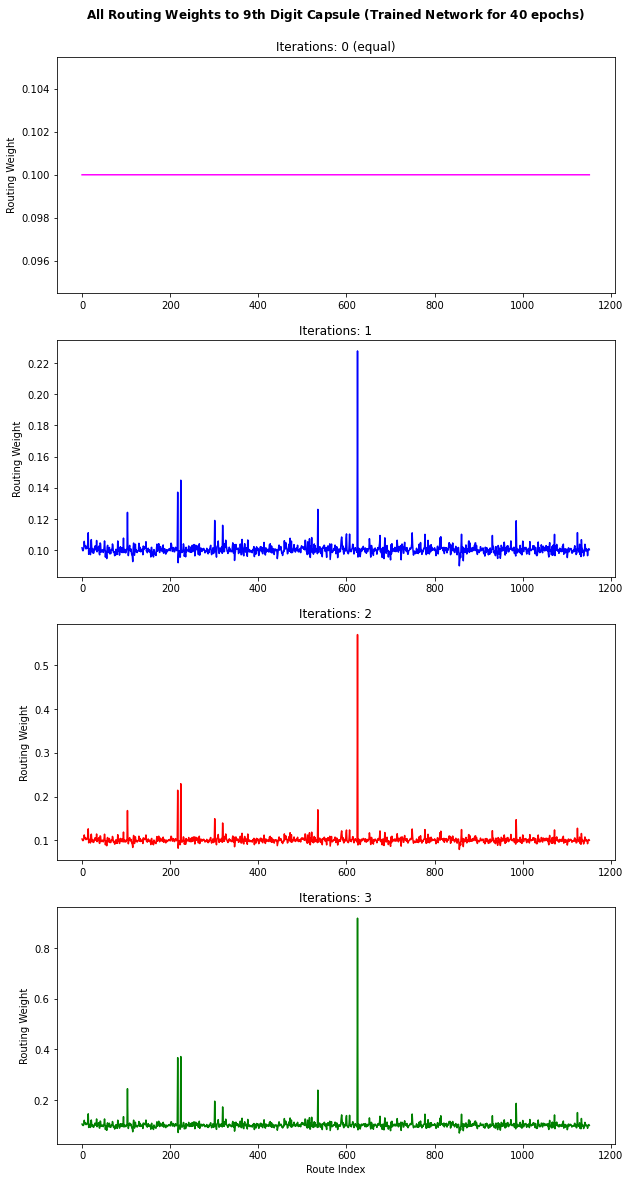

In [0]:
# Routes from 1st primary capsule to 7th (true digit capsule) with equal routes
fig = plt.figure(figsize=(10,20))
ax = fig.add_subplot(111)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title(r"$\bf{All\ Routing\ Weights\ to\ 9th\ Digit\ Capsule\ (Trained\ Network\ for\ 40\ epochs)}$"+"\n\n")
ax.set_xlabel("Route Index")

ax1 = fig.add_subplot(4,1,1)
ax1.set_title("Iterations: 0 (equal)")
#ax1.set_xlabel("Route Index")
ax1.set_ylabel("Routing Weight")
ax2 = fig.add_subplot(4,1,2)
ax2.set_title("Iterations: 1")
#ax2.set_xlabel("Route Index")
ax2.set_ylabel("Routing Weight")
ax3 = fig.add_subplot(4,1,3)
ax3.set_title("Iterations: 2")
#ax3.set_xlabel("Route Index")
ax3.set_ylabel("Routing Weight")
ax4 = fig.add_subplot(4,1,4)
ax4.set_title("Iterations: 3")
#ax4.set_xlabel("Route Index")
ax4.set_ylabel("Routing Weight")

ax1.plot(routes_40[0,20,:,9].cpu().numpy(),color='magenta')

# Routes from 1st primary capsule to 7th (true digit capsule) with 1 iteration
ax2.plot(routes_40[1,20,:,9].cpu().numpy(), color='blue')

# Routes from 1st primary capsule to 7th (true digit capsule) with 2 iterations
ax3.plot(routes_40[2,20,:,9].cpu().numpy(),color='red')

# Routes from 1st primary capsule to 7th (true digit capsule) with 3 iterations
ax4.plot(routes_40[3,20,:,9].cpu().numpy(),color='green')

fig.savefig("40 epochs trained CapsNet Routes progression")

In [0]:
from google.colab import drive
drive.mount("./gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at ./gdrive


### Sparsity Plot

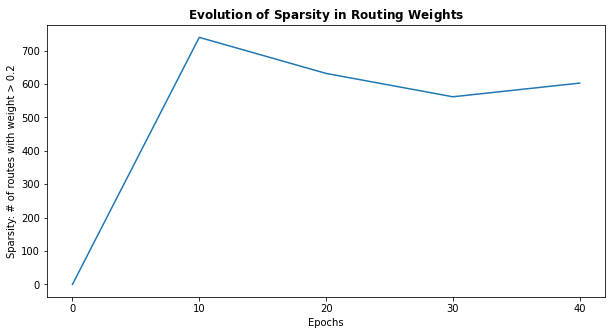

In [63]:
sparsity_count = np.array([0, 740, 632, 562, 603])
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1)
ax.set_xticks([0,10,20,30,40])
ax.set_xlabel("Epochs")
ax.set_ylabel("Sparsity: # of routes with weight > 0.2")
ax.set_title(r"$\bf{Evolution\ of\ Sparsity\ in\ Routing\ Weights}$")
ax.plot(np.arange(0,41,10),sparsity_count)
fig.savefig("sparsity_plot")

### Dot product of v_j and u_hat at different iterations

In [32]:
torch.argmax(torch.norm(v[20],dim=1))

tensor(9, device='cuda:0')

In [33]:
u_hat.shape

torch.Size([128, 1152, 10, 16])

In [34]:
outs.shape

torch.Size([4, 128, 10, 16])

#### Iteration 0 - Equally Weighted $v_j$

In [45]:
batch_index = 20
agreements = outs[0,batch_index].unsqueeze(dim=0)*u_hat[batch_index]
norms = torch.norm(agreements,dim=2)

torch.Size([1152, 10])

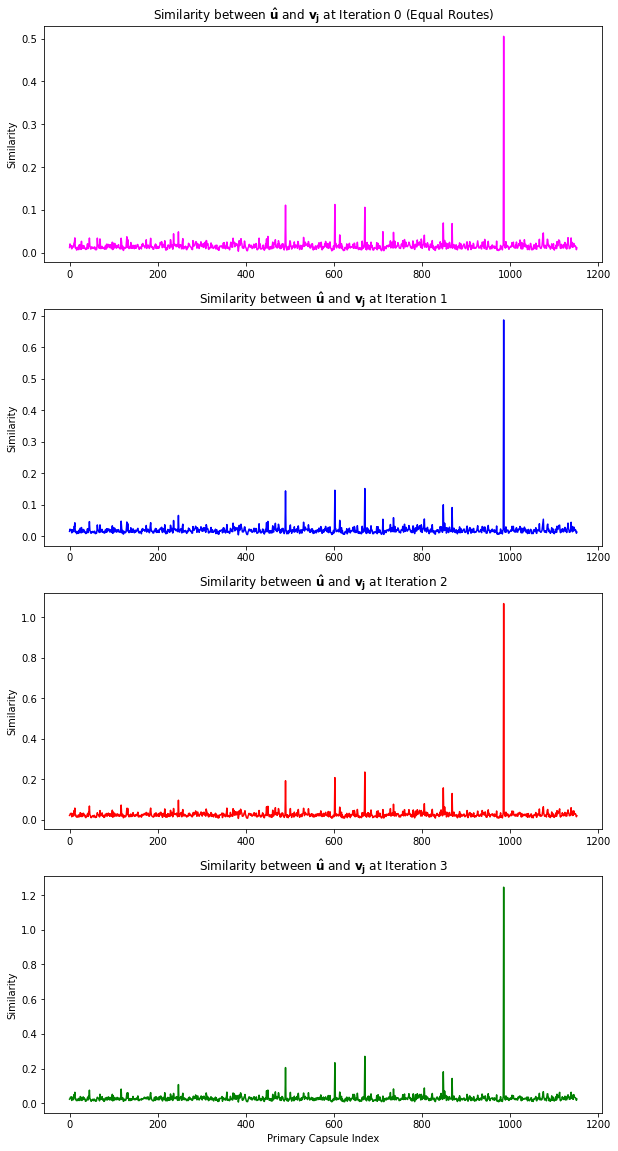

In [61]:
# All primary caps connected to true class (9th digit caps)
fig = plt.figure(figsize=(10,20))
batch_index = 20
main = fig.add_subplot(1,1,1)
main.set_xlabel("Primary Capsule Index")
main.spines['top'].set_color('none')
main.spines['bottom'].set_color('none')
main.spines['left'].set_color('none')
main.spines['right'].set_color('none')
main.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax = fig.add_subplot(4,1,1)
#ax.set_xlabel("Primary Capsule Index")
ax.set_ylabel("Similarity")
ax.set_title("Similarity between " + r"$\bf{\hat{u}}$" + " and " + r"$\bf{v_j}$" + " at Iteration 0 (Equal Routes)")
agreements = outs[0,batch_index].unsqueeze(dim=0)*u_hat[batch_index]
norms = torch.norm(agreements,dim=2)
ax.plot(norms[:,9].cpu().detach().numpy(),color='magenta')

ax1 = fig.add_subplot(4,1,2)
# ax1.set_xlabel("Primary Capsule Index")
ax1.set_ylabel("Similarity")
ax1.set_title("Similarity between " + r"$\bf{\hat{u}}$" + " and " + r"$\bf{v_j}$" + " at Iteration 1")
agreements = outs[1,batch_index].unsqueeze(dim=0)*u_hat[batch_index]
norms = torch.norm(agreements,dim=2)
ax1.plot(norms[:,9].cpu().detach().numpy(),color='blue')

ax2 = fig.add_subplot(4,1,3)
#ax2.set_xlabel("Primary Capsule Index")
ax2.set_ylabel("Similarity")
ax2.set_title("Similarity between " + r"$\bf{\hat{u}}$" + " and " + r"$\bf{v_j}$" + " at Iteration 2")
agreements = outs[2,batch_index].unsqueeze(dim=0)*u_hat[batch_index]
norms = torch.norm(agreements,dim=2)
ax2.plot(norms[:,9].cpu().detach().numpy(),color='red')

ax3 = fig.add_subplot(4,1,4)
#ax3.set_xlabel("Primary Capsule Index")
ax3.set_ylabel("Similarity")
ax3.set_title("Similarity between " + r"$\bf{\hat{u}}$" + " and " + r"$\bf{v_j}$" + " at Iteration 3")
agreements = outs[3,batch_index].unsqueeze(dim=0)*u_hat[batch_index]
norms = torch.norm(agreements,dim=2)
ax3.plot(norms[:,9].cpu().detach().numpy(),color='green')

fig.savefig("similarity")

### Rotated Image Routes

torch.Size([128, 1, 28, 28])
(28, 28)


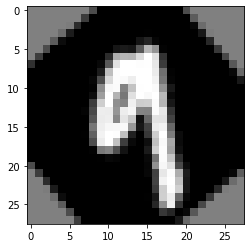

In [102]:
index=20
tdata_r=img.clone()
tdata_r=tdata_r.to(device)
print(tdata_r.size())
import cv2
image=tdata_r[index,0,:,:].detach().cpu().numpy()
def rotateImage(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result
out=rotateImage(image,40)
print(out.shape)
plt.imshow(out,cmap="gray")
plt.show()
tdata_r[index,0,:,:] = torch.from_numpy(out).to(device)
#cij_r,digit_cap_out,recon=net(tdata_r)
#true_class=target[index].item()
#print('Actual class:',true_class)
#prim_to_digit=cij_r[-1,index,:,true_class,0]
#plt.plot(prim_to_digit,color='green')
#plt.xlabel('Primary capsule index')
#plt.ylabel('Route weight')
#imp_routes1_r=np.argsort(prim_to_digit)[-max_routes:][max_routes::-1]

In [103]:
tdata_r.shape

torch.Size([128, 1, 28, 28])

In [0]:
vj,routes_rotate,_,_ = capsnet(tdata_r)

In [105]:
vj.shape

torch.Size([128, 10, 16])

In [106]:
torch.argmax(torch.norm(vj[20],dim=1))

tensor(9, device='cuda:0')

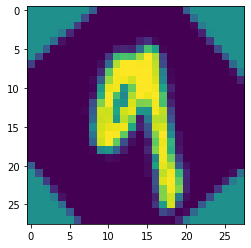

In [107]:
plt.imshow(tdata_r[20,0].cpu().numpy())

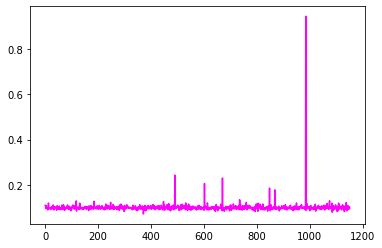

In [112]:
vj, routes_unrotate ,_,_ = capsnet(img)
plt.plot(routes_unrotate[3,20,:,9].cpu().numpy(),color='magenta')

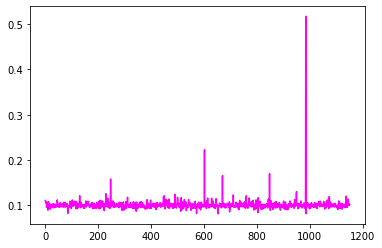

In [110]:
plt.plot(routes_rotate[3,20,:,9].cpu().numpy(),color='magenta')